<a href="https://colab.research.google.com/github/swicklund/hackathon/blob/main/MLModel-MilepostAtTime.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install -Uqq fastbook
!pip install dtreeviz
!gcloud config set project {'hackathon-352519'}

import os

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import fastbook as fastai
import pandas as pd
from pandas.io.json import json_normalize
import seaborn as sns
import tensorflow as tf
import json
import zipfile
from io import BytesIO
import torch
import math
from google.colab import files
from google.colab import auth
from datetime import datetime, timedelta

fastai.setup_book()
from fastai import tabular
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG

pd.options.display.max_rows = 20
pd.options.display.max_columns = 8
auth.authenticate_user()


     |████████████████████████████████| 719 kB 5.1 MB/s 
     |████████████████████████████████| 362 kB 42.6 MB/s 
     |████████████████████████████████| 4.4 MB 40.6 MB/s 
     |████████████████████████████████| 1.2 MB 26.1 MB/s 
     |████████████████████████████████| 101 kB 9.1 MB/s 
     |████████████████████████████████| 212 kB 49.3 MB/s 
     |████████████████████████████████| 140 kB 50.3 MB/s 
     |████████████████████████████████| 1.1 MB 37.9 MB/s 
     |████████████████████████████████| 596 kB 47.0 MB/s 
     |████████████████████████████████| 127 kB 49.3 MB/s 
     |████████████████████████████████| 94 kB 2.8 MB/s 
     |████████████████████████████████| 144 kB 55.2 MB/s 
     |████████████████████████████████| 271 kB 38.8 MB/s 
     |████████████████████████████████| 6.6 MB 35.1 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.

In [51]:
#filename = "train-data_all-train-events.zip"
#filename = "train-data-2022062020220626.zip"

#events-20-min includes reports for all trains in the a 2 week window reporting at most every 20 minutes 
filename = "train-events-20-min.zip"

# miles answers the question "what spped will this train be moving in X miles (technically at milepost +/-X)"
#measurement = { 'unit' : 'miles', 'size' : 1.0 }

# minutes answers the question : what speed will this train be moving in X Minutes
#measurement = { 'unit' : 'minutes', 'size' : 90.0 }

#dep_var = 'nextSpeed'

# milepost answers the question "What milepost will this train be at in X Minutes"
measurement = { 'unit' : 'milepost', 'size' : 20.0 }
dep_var = 'nextValue'

In [4]:
!gsutil cp gs://trains_data/$filename /tmp/.

Copying gs://trains_data/train-events-20-min.zip...
- [1 files][ 40.7 MiB/ 40.7 MiB]                                                
Operation completed over 1 objects/40.7 MiB.                                     


In [5]:
trains = {}
i = 1
with zipfile.ZipFile("/tmp/"+filename, "r") as f:
    for name in f.namelist():
        if name.endswith('.json'):
            with f.open(name) as zd:
                data = json.load(zd)
                lastTrainReporting = data['lastTrainReporting']
                currentLoco = lastTrainReporting['ptcLeadLocomotiveId']
                if ("trainActualPositionList" in lastTrainReporting and len(lastTrainReporting['trainActualPositionList']) > 0): 
                    trains[i] = pd.json_normalize(lastTrainReporting)
                    i = i + 1
                    if (i % 1000 == 0):
                      print(i, " ", datetime.now().strftime("%H:%M:%S"))
                            

1000   19:25:16
2000   19:25:28
3000   19:25:40
4000   19:25:45
5000   19:25:50
6000   19:25:56


In [6]:
dfTrainsAll = pd.concat(trains.values())
dfTrainsAll["milepost"] = dfTrainsAll.apply(lambda row: math.trunc(row['lastReportedPosition.milepostLocation.milepost.milepostNumber']), axis=1)

In [7]:
del trains

In [8]:
print(dfTrainsAll.info())
print(dfTrainsAll.shape)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6747 entries, 0 to 0
Data columns (total 37 columns):
 #   Column                                                         Non-Null Count  Dtype  
---  ------                                                         --------------  -----  
 0   ptcLeadLocomotiveId                                            6747 non-null   object 
 1   positionHistoryList                                            6747 non-null   object 
 2   locomotiveList                                                 6747 non-null   object 
 3   subdivisionList                                                6747 non-null   object 
 4   trainEstimatedPositionList                                     6747 non-null   object 
 5   trainActualPositionList                                        6747 non-null   object 
 6   trainId.trainSCAC                                              6747 non-null   object 
 7   trainId.trainSection                                           

# Create a learning set to modify

In [9]:
dfTrainsLearn = dfTrainsAll

Clear the nan values and replace with max values.

In [10]:
dfTrainsLearn['loadedCarCount'] =  dfTrainsLearn['loadedCarCount'].replace(np.nan, 999.)
dfTrainsLearn['emptyCarCount'] =  dfTrainsLearn['emptyCarCount'].replace(np.nan, 999.)
dfTrainsLearn['trainLength'] =  dfTrainsLearn['trainLength'].replace(np.nan, 99999.)
dfTrainsLearn['trailingTonnage'] =  dfTrainsLearn['trailingTonnage'].replace(np.nan, 99999.)

Determine if the train is moving milepost Increasing or decreasing.

In [11]:
dfTrainsLearn['mpIncr'] = dfTrainsLearn.apply(lambda row: row['lastReportedPosition.speedMPH'] >= 0, axis=1)

Make all speeds positive

In [12]:
dfTrainsLearn['lastReportedPosition.speedMPH']  = dfTrainsLearn.apply(lambda row: abs(row['lastReportedPosition.speedMPH']), axis=1)
dfTrainsLearn['maximumTrainSpeed']  = dfTrainsLearn.apply(lambda row: abs(row['maximumTrainSpeed']), axis=1)

Speed Distribution:


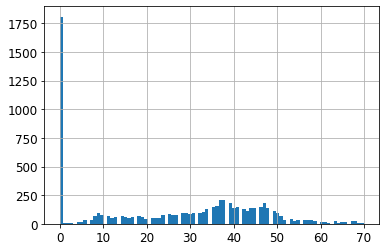

In [13]:
print("Speed Distribution:")
dfTrainsLearn['lastReportedPosition.speedMPH'].hist(bins=90)

Replace the NaN values in AOTU with zeros

In [14]:
aotuColumns = [item for item in dfTrainsLearn.columns if item.startswith('aotu')]
for column in aotuColumns:
  dfTrainsLearn[column] =  dfTrainsLearn[column].replace(np.nan, 0.)

Categorize the applicable variables

In [15]:
def categorize(aDataFrame, columnName, defaultReplacement):
  aDataFrame[columnName] = aDataFrame[columnName].fillna(value=defaultReplacement)
  categories = aDataFrame[columnName].unique()
  print(aDataFrame[columnName].unique())
  aDataFrame[columnName] = aDataFrame[columnName].astype('category')
  aDataFrame[columnName] = aDataFrame[columnName].cat.set_categories(categories)
  return aDataFrame

In [16]:
dfTrainsLearn['symbolType'] = dfTrainsLearn.apply(lambda row: row['trainId.trainSymbol'][:1], axis=1)
dfTrainsLearn = categorize(dfTrainsLearn, 'symbolType', "X")
dfTrainsLearn = categorize(dfTrainsLearn, 'lastReportedPosition.milepostLocation.trackName', "UNKNOWN")
dfTrainsLearn = categorize(dfTrainsLearn, 'trainId.trainSCAC',"UNK")
dfTrainsLearn = categorize(dfTrainsLearn, 'trainId.trainSection', ' ')
dfTrainsLearn = categorize(dfTrainsLearn, 'aotuTrainData.priorityCode', 0)  # may want to order these
dfTrainsLearn = categorize(dfTrainsLearn, 'aotuTrainData.categoryCode', 0)
dfTrainsLearn = categorize(dfTrainsLearn, 'aotuTrainData.authorityRangeCode', 0)
dfTrainsLearn = categorize(dfTrainsLearn, 'aotuTrainData.ownershipCode', 0)
dfTrainsLearn = categorize(dfTrainsLearn, 'aotuTrainData.tenantCarrier', "0")
dfTrainsLearn = categorize(dfTrainsLearn, 'aotuTrainData.eventCode', 0)
 

['A' 'Q' 'M' 'H' 'G' 'U' 'I' 'O' 'E' 'C' 'Y' 'L' 'Z' 'S' 'R' 'W']
['TO_S_UP_MAINLINE' 'WEST MAIN' 'EAST MAIN' 'TO_N_EAST MAIN' 'MAIN' 'S_LUCAS' 'NEW LACY TRACK' 'MAIN CHAISON YARD' 'MT 2' 'MT 1' 'S_VIDOR' 'TO_S_VIDOR' 'TO_S_CS JUNCTION' 'S_HELME' 'EASTXO'
 'TO_S_KCS UP PRT CONN' 'KCS UP PORT CONNECT' 'WESTXO' 'N SIDING' 'XO' 'TO_N_HELME' 'TO_N_CHAISON MAIN' 'TO_N_LUCAS' 'TO_N_STARKS' 'S_STARKS' 'S_MAURICEVILLE' 'TO_S_LUCAS' 'TO_N_MAURICEVILLE' 'YD LD'
 'TO_N_VIDOR' 'S_FISHER' 'S_CONVERSE' 'S_ANACOCO' 'S_NEAME' 'S_LEESVILLE']
['UP']
['' '2' '3' '4' '5']
[1. 2. 0. 4. 3.]
[14. 12.  0.  9.  8. 10. 18. 15.  4. 20. 11.  2. 17. 16. 13. 19.]
[2. 0. 3. 1.]
[3. 0. 2.]
['AMTK' 'BNSF' 0.0 '' 'KCS']
[0.]


Replace unknown max speeds with 88 miles per hour (to make them recognizable)

In [17]:
dfTrainsLearn['maximumTrainSpeed'] =  dfTrainsLearn['maximumTrainSpeed'].replace(np.nan, 88.)
print(dfTrainsLearn['maximumTrainSpeed'].unique())

[88. 50. 60. 70. 40. 45. 30.]


Flatten out the work locations (we may want to change this for the NN algorithm)

In [18]:
def getWorkLocations(dfTrainsLocation):
  if isinstance(dfTrainsLocation['aotuTrainData.routeLocationList'], float):
    return None
  if len(dfTrainsLocation['aotuTrainData.routeLocationList']) == 0:
    return None
  aotuRoute=pd.json_normalize(dfTrainsLocation['aotuTrainData.routeLocationList']) 
  eventLocations = aotuRoute[aotuRoute['activityList'].map(len) > 1]
  temp = eventLocations['milepost.milepostNumber'].unique()
  if len(temp) == 0:
    return None
  return ','.join(['%.2f' % num for num in temp])

In [19]:
dfTrainsLearn['workLocations'] = dfTrainsLearn.apply(lambda row: getWorkLocations(row), axis=1)

In [20]:
dfTrainsLearn['workLocations'].unique()

array([None, '202.20', '225.10', '202.20,219.70', '202.20,258.40,321.50', '202.20,258.40', '219.70,202.20', '250.50,202.20', '258.40,202.20', '258.40,207.60,202.20', '321.50,202.20', '202.20,314.52',
       '202.20,214.50,225.10,290.80,304.10', '214.50,225.10,290.80,304.10,202.20', '321.50,314.52,202.20', '258.40,219.70,202.20', '314.52,202.20', '257.60,202.20', '202.20,265.30',
       '202.20,258.40,318.90,321.50', '202.20,219.70,258.40,321.50', '202.20,219.70,250.50,258.40,321.50', '258.40,214.50,202.20', '202.20,219.70,258.40', '225.10,202.20'], dtype=object)

determine the locomotive count from the locomotive list.  We can make this more clever later, but for now this seems the most sensible shortcut

In [21]:
dfTrainsLearn['locomotiveCount'] = dfTrainsLearn.apply(lambda row: len(row['locomotiveList']),axis = 1)

Convert the list of actual reportings into a dataframe.

In [22]:
dfTrainsLearnActuals = dfTrainsLearn.apply(lambda row: pd.json_normalize(row['trainActualPositionList']), axis=1)

In [23]:
def showTrain(idx):
  print(dfTrainsLearn.iloc[idx]['ptcLeadLocomotiveId'])
  print(dfTrainsLearn.iloc[idx]['trainId.trainSymbol'])


You can peer into the incoming data here:

In [24]:
idx = 201
showTrain(idx)
dfTrainsLearnActuals.iloc[idx]

KCS4151
MRNWAJ


,positionTime,speedMPH,milepostLocation.subdivisionId,milepostLocation.trackName,milepostLocation.milepost.milepostNumber
0,2022-07-01T02:21:09Z,0,106,WEST MAIN,766.24380
1,2022-07-01T02:23:09Z,0,106,WEST MAIN,766.24380
2,2022-07-01T02:25:09Z,-1,106,WEST MAIN-MAIN,766.19920
3,2022-07-01T02:27:09Z,-5,106,WEST MAIN-MAIN,766.11084
4,2022-07-01T02:29:09Z,-9,106,MAIN,765.94490
...,...,...,...,...,...
16,2022-07-01T02:53:09Z,-8,106,S_VIDOR,761.16580
17,2022-07-01T02:55:09Z,-7,106,S_VIDOR,760.92035
18,2022-07-01T02:57:09Z,-6,106,S_VIDOR,760.67960
19,2022-07-01T02:59:09Z,-4,106,S_VIDOR,760.45135


In [25]:
dfTrainsBeop =  dfTrainsLearn[['lastReportedPosition.milepostLocation.milepost.milepostNumber','trainEstimatedPositionList']]
dfTrainsBeop

,lastReportedPosition.milepostLocation.milepost.milepostNumber,trainEstimatedPositionList
0,764.8696,[]
0,764.8706,[]
0,766.9310,[]
0,764.8691,[]
0,766.9302,[]
...,...,...
0,290.7408,"[{'positionTime': '2022-06-23T10:15:47Z', 'speedMPH': 12, 'milepostLocation': {'subdivisionId': 106, 'trackName': 'EASTXO', 'milepost': {'milepostNumber': 290.7408}}}, {'positionTime': '2022-06-23T10:17:47Z', 'speedMPH': 30, 'milepostLocation': {'subdivisionId': 106, 'trackName': 'EASTXO', 'milepost': {'milepostNumber': 291.4418}}}, {'positionTime': '2022-06-23T10:19:47Z', 'speedMPH': 40, 'milepostLocation': {'subdivisionId': 106, 'trackName': 'EASTXO', 'milepost': {'milepostNumber': 292.6651}}}, {'positionTime': '2022-06-23T10:21:47Z', 'speedMPH': 49, 'milepostLocation': {'subdivisionId':..."
0,293.2164,[]
0,294.0817,"[{'positionTime': '2022-06-23T11:17:23Z', 'speedMPH': 23, 'milepostLocation': {'subdivisionId': 106, 'trackName': 'MT 2', 'milepost': {'milepostNumber': 294.0817}}}, {'positionTime': '2022-06-23T11:19:23Z', 'speedMPH': 35, 'milepostLocation': {'subdivisionId': 106, 'trackName': 'MT 2', 'milepost': {'milepostNumber': 295.03876}}}, {'positionTime': '2022-06-23T11:21:23Z', 'speedMPH': 45, 'milepostLocation': {'subdivisionId': 106, 'trackName': 'MT 2', 'milepost': {'milepostNumber': 296.39496}}}, {'positionTime': '2022-06-23T11:23:23Z', 'speedMPH': 50, 'milepostLocation': {'subdivisionId': 106..."
0,305.3550,"[{'positionTime': '2022-06-23T11:34:06Z', 'speedMPH': 48, 'milepostLocation': {'subdivisionId': 106, 'trackName': 'MT 1', 'milepost': {'milepostNumber': 305.355}}}, {'positionTime': '2022-06-23T11:36:06Z', 'speedMPH': 50, 'milepostLocation': {'subdivisionId': 106, 'trackName': 'MT 1', 'milepost': {'milepostNumber': 307.01364}}}, {'positionTime': '2022-06-23T11:38:06Z', 'speedMPH': 50, 'milepostLocation': {'subdivisionId': 106, 'trackName': 'MT 1', 'milepost': {'milepostNumber': 308.68835}}}, {'positionTime': '2022-06-23T11:40:06Z', 'speedMPH': 50, 'milepostLocation': {'subdivisionId': 106,..."


Renumber the list

In [26]:
dfTrainsLearn = dfTrainsLearn.reset_index(drop=True)

# Determine NextValue
This will be the value we are attempting to learn

In [53]:
def findNextTime(trainsEntry, actualsEntry, timeInMinutes):
  #print(actualsEntry.iloc[4]['speedMPH'], " - ",trainsEntry['lastReportedPosition.speedMPH'] )
  idx = math.trunc(timeInMinutes // 2)
  if (idx < len(actualsEntry)):
    return (abs(actualsEntry.iloc[idx]['speedMPH']) - abs(trainsEntry['lastReportedPosition.speedMPH']))
  return None

In [54]:
def findNextMilepost(trainsEntry, actualsEntry, distance):
  currMilepost = trainsEntry['lastReportedPosition.milepostLocation.milepost.milepostNumber']
  value  = actualsEntry.loc[actualsEntry['milepostLocation.milepost.milepostNumber'] > currMilepost + distance]
  if (len(value) > 0) :
    return value[value['milepostLocation.milepost.milepostNumber'] == value['milepostLocation.milepost.milepostNumber'].min()]
  value  = actualsEntry.loc[actualsEntry['milepostLocation.milepost.milepostNumber'] < currMilepost - distance]
  if (len(value) > 0):
    return value[value['milepostLocation.milepost.milepostNumber'] == value['milepostLocation.milepost.milepostNumber'].max()]
  return []

In [55]:
def findNextMilepostAtTime(trainsEntry, actualsEntry, timeInMinutes):
  idx = math.trunc(timeInMinutes // 2)
  if (idx < len(actualsEntry)):
    return actualsEntry.iloc[idx]['milepostLocation.milepost.milepostNumber']
  return None

In [56]:
def findNextSpeed(trainsEntry, actualsEntry):
  if (measurement.get('unit') == 'miles'):
    nextActual = findNextMilepost(trainsEntry, actualsEntry, measurement.get('size'))
    if (nextActual != None and len(nextActual) > 0):
      amt = (abs(nextActual.iloc[0]['speedMPH']) - abs(trainsEntry['lastReportedPosition.speedMPH']))
      return amt;
  elif (measurement.get('unit') == 'minutes'):
    return findNextTime(trainsEntry, actualsEntry, measurement.get('size'))
  elif (measurement.get('unit') == 'milepost'):
    return findNextMilepostAtTime(trainsEntry, actualsEntry, measurement.get('size'))
  else:
    raise Exception('unknown measurement', measurement.get('unit'))    
  return None

You can peer into the mechanics of a lookup here:

In [57]:
idx = 3291
showTrain(idx)
print("Reported speed: ", dfTrainsLearn.iloc[idx]['lastReportedPosition.speedMPH'])
print("Reported MP: ", dfTrainsLearn.iloc[idx]['lastReportedPosition.milepostLocation.milepost.milepostNumber'])
print("Reported Time: ", dfTrainsLearn.iloc[idx]['lastReportedPosition.positionTime'])

nextActual = findNextMilepost(dfTrainsLearn.iloc[idx], dfTrainsLearnActuals.iloc[idx], 1)
print("Next Speed at MP:",nextActual)
nextActual = findNextTime(dfTrainsLearn.iloc[idx], dfTrainsLearnActuals.iloc[idx], 10)
print("Next Speed at 10 Min:",nextActual)
nextActual = findNextMilepostAtTime(dfTrainsLearn.iloc[idx], dfTrainsLearnActuals.iloc[idx], 10)
print("Milepost in 10 Min:",nextActual)

print("actual Value: ", findNextSpeed(dfTrainsLearn.iloc[idx], dfTrainsLearnActuals.iloc[idx]))
beopJSON = dfTrainsBeop.iloc[idx]['trainEstimatedPositionList']
if not type(beopJSON) is float and len(beopJSON) > 0:
  beopDT = pd.json_normalize(beopJSON)
  nextBeop = findNextMilepost(dfTrainsLearn.iloc[idx], beopDT, 1)
  print(nextBeop)
  type(dfTrainsBeop.iloc[idx]['trainEstimatedPositionList'])
  print("beop Value: ", findNextSpeed(dfTrainsLearn.iloc[idx], beopDT))

UP6579
CNAPW9
Reported speed:  42
Reported MP:  315.8773
Reported Time:  2022-06-26T02:15:16Z
Next Speed at MP:            positionTime  speedMPH  milepostLocation.subdivisionId  \
0  2022-06-26T02:17:16Z       -43                             106   

  milepostLocation.trackName  milepostLocation.milepost.milepostNumber  
0                       MT 2                                 314.40375  
Next Speed at 10 Min: 8
Milepost in 10 Min: 306.50928
actual Value:  296.73306
           positionTime  speedMPH  milepostLocation.subdivisionId  \
1  2022-06-26T02:17:16Z       -44                             106   

  milepostLocation.trackName  milepostLocation.milepost.milepostNumber  
1                       MT 2                                  314.4466  
beop Value:  299.73553


Run the calulations.  This will take a moment.

In [58]:
dfTrainsLearn['nextValue'] = np.NaN
dfTrainsLearn['beopValue'] = np.NaN
i = 0;
for index, trainsEntry in dfTrainsLearn.iterrows():
  nextValue = findNextSpeed(trainsEntry, dfTrainsLearnActuals.iloc[i])
  if (nextValue != None):
    dfTrainsLearn.at[i,'nextValue'] = nextValue
  beopJSON = dfTrainsBeop.iloc[i]['trainEstimatedPositionList']
  if not type(beopJSON) is float and len(beopJSON) > 0:
    try:
      beopDT = pd.json_normalize(beopJSON)
      if (measurement.get('unit') == 'miles'):
        nextBeop = findNextMilepost(trainsEntry, beopDT, measurement.get('size'))
      elif (measurement.get('unit') == 'minutes'):
        nextBeop = findNextTime(trainsEntry, beopDT, measurement.get('size'))
      elif (measurement.get('unit') == 'milepost'):
        nextBeop = findNextMilepostAtTime(trainsEntry, beopDT, measurement.get('size'))
      if (nextBeop != None):
        dfTrainsLearn.at[i,'beopValue'] = nextBeop
    except NotImplementedError:
      print(type(beopJSON))
    except KeyError:
      print(beopJSON)
  if (i % 1000 == 0):
    print(i)
  i = i + 1

0
1000
2000
3000
4000
5000
6000


In [59]:
dfTrainsLearn = dfTrainsLearn.dropna(subset=['nextValue'])
dfTrainsLearn['nextValue'].unique()

array([765.4534 , 766.2368 , 766.57025, ..., 297.7107 , 309.46198, 321.9232 ])

NextSpeed values histogram:


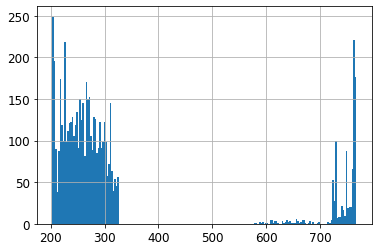

In [60]:
print("NextSpeed values histogram:")
dfTrainsLearn['nextValue'].hist(bins=200)

In [62]:
dfTrainsLearn['beopValue'].unique()

array([      nan, 731.8421 , 738.4649 , ..., 305.0763 , 309.55542, 321.7972 ])

physics predictions histogram:


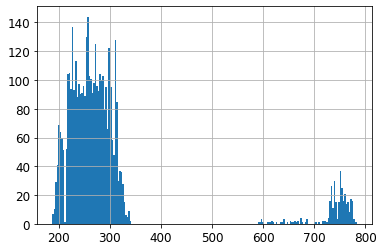

In [63]:
print("physics predictions histogram:")
dfTrainsLearn['beopValue'].hist(bins=200)

In [64]:
dfTrainsNextBeop = dfTrainsLearn['beopValue']

Drop some values we are not using at the moment, not needed.

Note, this will disable above computations unless you resume at "Create a learning set"

In [65]:
dfTrainsLearn = dfTrainsLearn.drop(columns=['aotuTrainData.tenantCarrier',
                                            'beopValue',
                                            'positionHistoryList',
                                            'locomotiveList',
                                            'subdivisionList',
                                            'trainActualPositionList',
                                            'trainEstimatedPositionList',
                                            'aotuTrainData.routeLocationList'])

Burst dates into subcolumns that might prove useful

In [66]:
tabular.core.make_date(dfTrainsLearn, 'trainId.trainDate')
tabular.core.make_date(dfTrainsLearn, 'lastReportedPosition.positionTime')
tabular.core.add_datepart(dfTrainsLearn, 'lastReportedPosition.positionTime')
# tabular.core.add_elapsed_times(dfTrainsLearn, 'lastReportedPosition.positionTime')


,ptcLeadLocomotiveId,trainId.trainSCAC,trainId.trainSection,trainId.trainSymbol,...,lastReportedPosition.positionTimeIs_quarter_start,lastReportedPosition.positionTimeIs_year_end,lastReportedPosition.positionTimeIs_year_start,lastReportedPosition.positionTimeElapsed
10,BNSF3836,UP,,QDYIJJ,...,False,False,False,1.656589e+09
23,BNSF5040,UP,,QDYIJJ,...,False,False,False,1.656024e+09
32,BNSF5746,UP,,QBTIJJ,...,False,False,False,1.655822e+09
34,BNSF5833,UP,,MNOEW,...,False,False,False,1.655754e+09
35,BNSF5833,UP,,MNOEW,...,False,False,False,1.655755e+09
...,...,...,...,...,...,...,...,...,...
6741,UP9101,UP,,MCHCB,...,False,False,False,1.655978e+09
6742,UP9101,UP,,MCHCB,...,False,False,False,1.655979e+09
6743,UP9101,UP,,MCHCB,...,False,False,False,1.655982e+09
6744,UP9101,UP,,MCHCB,...,False,False,False,1.655983e+09


In [67]:
print(dfTrainsLearn.shape)
print(dfTrainsLearnActuals.shape)

print(dfTrainsLearn.info())
print(dfTrainsLearn.iloc[10])

(5907, 47)
(6747,)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 5907 entries, 10 to 6745
Data columns (total 47 columns):
 #   Column                                                         Non-Null Count  Dtype         
---  ------                                                         --------------  -----         
 0   ptcLeadLocomotiveId                                            5907 non-null   object        
 1   trainId.trainSCAC                                              5907 non-null   category      
 2   trainId.trainSection                                           5907 non-null   category      
 3   trainId.trainSymbol                                            5907 non-null   object        
 4   trainId.trainDate                                              5907 non-null   datetime64[ns]
 5   lastReportedPosition.speedMPH                                  5907 non-null   int64         
 6   lastReportedPosition.milepostLocation.subdivisionId            5907 non-null

# Use Decision Tree to predict next speed

In [68]:
procs = [tabular.core.Categorify, tabular.core.FillMissing]

Breakdown the data by day of year - we will train with older data and then test the model with newer values.
Note: this simple logic will fail at the begining of a new year!

In [69]:
dateValues = dfTrainsLearn.groupby(['lastReportedPosition.positionTimeDayofyear'])['lastReportedPosition.positionTimeDayofyear'].count()
print(dateValues)

lastReportedPosition.positionTimeDayofyear
171    448
172    460
173    518
174    688
175    583
176    522
177    548
178    511
179    513
180    487
181    507
182    122
Name: lastReportedPosition.positionTimeDayofyear, dtype: int64


In [70]:
print("We will partition this set at day of year:", dateValues.index[math.trunc(dateValues.size * .66)])

We will partition this set at day of year: 178


In [71]:
cond = ( dfTrainsLearn['lastReportedPosition.positionTimeDayofyear'] <= dateValues.index[math.trunc(dateValues.size * .66)] )
trainIdx = np.where(cond)[0]
validIdx = np.where(~cond)[0]
splits = (list(trainIdx), list(validIdx))

In [43]:
#dep_var = 'nextSpeed'

In [72]:
cont,cat = tabular.core.cont_cat_split(dfTrainsLearn, 1, dep_var=dep_var)

In [73]:
to = tabular.core.TabularPandas(dfTrainsLearn, procs, cat, cont, y_names=dep_var, splits=splits)

In [74]:
len(to.train),len(to.valid)

(4278, 1629)

In [75]:
to.show()

,ptcLeadLocomotiveId,trainId.trainSCAC,trainId.trainSection,trainId.trainSymbol,trainId.trainDate,lastReportedPosition.milepostLocation.subdivisionId,lastReportedPosition.milepostLocation.trackName,aotuTrainData.priorityCode,aotuTrainData.categoryCode,aotuTrainData.authorityRangeCode,aotuTrainData.ownershipCode,aotuTrainData.eventCode,mpIncr,symbolType,workLocations,lastReportedPosition.positionTimeYear,lastReportedPosition.positionTimeIs_month_end,lastReportedPosition.positionTimeIs_month_start,lastReportedPosition.positionTimeIs_quarter_end,lastReportedPosition.positionTimeIs_quarter_start,lastReportedPosition.positionTimeIs_year_end,lastReportedPosition.positionTimeIs_year_start,lastReportedPosition.speedMPH,lastReportedPosition.milepostLocation.milepost.milepostNumber,aotuTrainData.totalCarWeight,aotuTrainData.totalCarLength,aotuTrainData.totalLocomotiveWeight,aotuTrainData.totalLocomotiveLength,aotuTrainData.actualTonsPerAxle,aotuTrainData.heavy143TonCarCount,aotuTrainData.heavy158TonCarCount,aotuTrainData.over158TonCarCount,aotuTrainData.highWideCarCount,maximumTrainSpeed,loadedCarCount,emptyCarCount,trainLength,trailingTonnage,milepost,locomotiveCount,lastReportedPosition.positionTimeMonth,lastReportedPosition.positionTimeWeek,lastReportedPosition.positionTimeDay,lastReportedPosition.positionTimeDayofweek,lastReportedPosition.positionTimeDayofyear,lastReportedPosition.positionTimeElapsed,nextValue
23,BNSF5040,UP,,QDYIJJ,2022-06-22,106,EAST MAIN,2.0,12.0,2.0,3.0,0.0,False,Q,#na#,2022,False,False,False,False,False,False,14,766.864807,0.0,0.0,8520000.0,17560.0,65535.0,0.0,0.0,0.0,0.0,88.0,999.0,999.0,99999.0,99999.0,766,0,6,25,23,3,174,1.656024e+09,766.236816
32,BNSF5746,UP,,QBTIJJ,2022-06-21,106,EAST MAIN,2.0,12.0,2.0,3.0,0.0,True,Q,#na#,2022,False,False,False,False,False,False,6,766.783325,57140000.0,362880.0,12550000.0,26440.0,65535.0,0.0,0.0,0.0,0.0,88.0,999.0,999.0,99999.0,99999.0,766,0,6,25,21,1,172,1.655822e+09,766.570251
34,BNSF5833,UP,,MNOEW,2022-06-19,106,MAIN,4.0,12.0,2.0,2.0,0.0,True,M,#na#,2022,False,False,False,False,False,False,8,720.410889,100343000.0,857270.0,4200000.0,8780.0,65535.0,6.0,0.0,0.0,0.0,50.0,10.0,115.0,7274.0,5018.0,720,1,6,25,20,0,171,1.655754e+09,727.289551
35,BNSF5833,UP,,MNOEW,2022-06-19,106,MAIN,4.0,12.0,2.0,2.0,0.0,True,M,#na#,2022,False,False,False,False,False,False,28,724.460693,100343000.0,857270.0,4200000.0,8780.0,65535.0,6.0,0.0,0.0,0.0,50.0,10.0,115.0,7274.0,5018.0,724,1,6,25,20,0,171,1.655755e+09,728.696289
36,BNSF5833,UP,,MNOEW,2022-06-19,106,S_LUCAS,4.0,12.0,2.0,2.0,0.0,True,M,#na#,2022,False,False,False,False,False,False,0,728.696106,100343000.0,857270.0,4200000.0,8780.0,65535.0,6.0,0.0,0.0,0.0,50.0,10.0,115.0,7274.0,5018.0,728,1,6,25,20,0,171,1.655756e+09,728.696411
37,BNSF5833,UP,,MNOEW,2022-06-19,106,S_LUCAS,4.0,12.0,2.0,2.0,0.0,True,M,#na#,2022,False,False,False,False,False,False,0,728.696411,100343000.0,857270.0,4200000.0,8780.0,65535.0,6.0,0.0,0.0,0.0,50.0,10.0,115.0,7274.0,5018.0,728,1,6,25,20,0,171,1.655757e+09,728.697998
38,BNSF5833,UP,,MNOEW,2022-06-19,106,S_LUCAS,4.0,12.0,2.0,2.0,0.0,True,M,#na#,2022,False,False,False,False,False,False,0,728.697998,100343000.0,857270.0,4200000.0,8780.0,65535.0,6.0,0.0,0.0,0.0,50.0,10.0,115.0,7274.0,5018.0,728,1,6,25,20,0,171,1.655758e+09,728.697021
39,BNSF5833,UP,,MNOEW,2022-06-19,106,S_LUCAS,4.0,12.0,2.0,2.0,0.0,True,M,#na#,2022,False,False,False,False,False,False,0,728.697388,100343000.0,857270.0,4200000.0,8780.0,65535.0,6.0,0.0,0.0,0.0,50.0,10.0,115.0,7274.0,5018.0,728,1,6,25,20,0,171,1.655759e+09,728.696777
40,BNSF5833,UP,,MNOEW,2022-06-19,106,S_LUCAS,4.0,12.0,2.0,2.0,0.0,True,M,#na#,2022,False,False,False,False,False,False,0,728.696594,100343000.0,857270.0,4200000.0,8780.0,65535.0,6.0,0.0,0.0,0.0,50.0,10.0,115.0,7274.0,5018.0,728,1,6,25,20,0,171,1.655761e+09,728.696777
41,BNSF5833,UP,,MNOEW,2022-06-19,106,S_LUCAS,4.0,12.0,2.0,2.0,0.0,True,M,#na#,2022,False,False,False,False,False,False,0,728.696594,100343000.0,857270.0,4200000.0

In [76]:
fastai.save_pickle('/tmp/to.pkl',to)

# Creating the Decision Tree

In [77]:
to = fastai.load_pickle('/tmp/to.pkl')

In [78]:
xs,y = to.train.xs,to.train.y
valid_xs,valid_y = to.valid.xs,to.valid.y

In [79]:
m = DecisionTreeRegressor(max_leaf_nodes=16)
m.fit(xs, y);

Here is a sample of a Decision Tree with just 16 nodes:

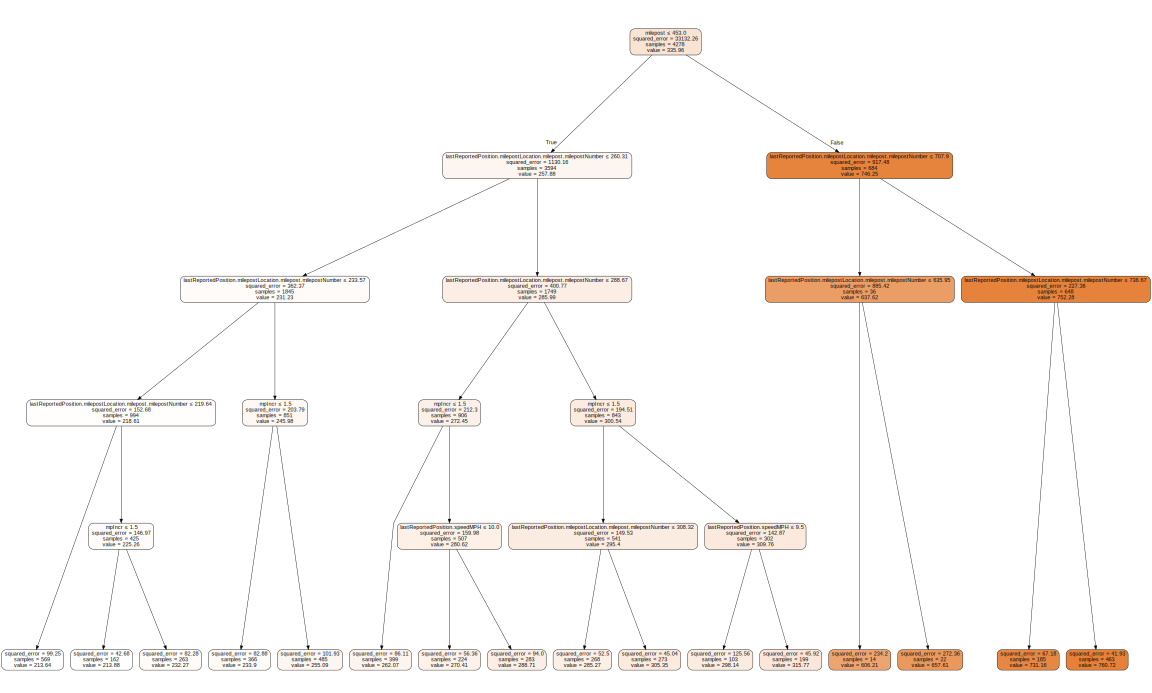

In [80]:
fastai.draw_tree(m, xs, size=16, leaves_parallel=True, precision=2)

In [81]:
m = DecisionTreeRegressor(min_samples_leaf=9)
m.fit(xs, y);

In [82]:
def r_mse(pred,y): return round(math.sqrt(((pred-y)**2).mean()), 6)
def m_rmse(m, xs, y): return r_mse(m.predict(xs), y)

How well we fit the traing model:

In [83]:
m_rmse(m, xs, y)

3.456412

How well we fit the Validation Model:

In [84]:
m_rmse(m, valid_xs, valid_y)

5.529977

In [85]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

In [86]:
fi = rf_feat_importance(m, xs)
fi[:10]

,cols,imp
38,milepost,0.967872
23,lastReportedPosition.milepostLocation.milepost.milepostNumber,0.029237
12,mpIncr,0.001833
22,lastReportedPosition.speedMPH,0.000922
3,trainId.trainSymbol,0.000043
45,lastReportedPosition.positionTimeElapsed,0.000014
34,loadedCarCount,0.000010
25,aotuTrainData.totalCarLength,0.000009
36,trainLength,0.000008
35,emptyCarCount,0.000007


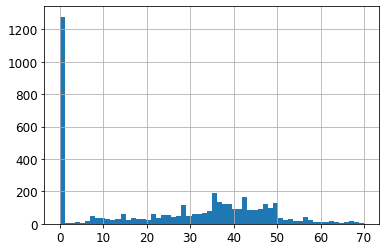

In [87]:
ax = xs['lastReportedPosition.speedMPH'].hist(bins=60)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_partial_dependence is deprecated; Function `plot_partial_dependence` is deprecated in 1.0 and will be removed in 1.2. Use PartialDependenceDisplay.from_estimator instead
  warnings.warn(msg, category=FutureWarning)


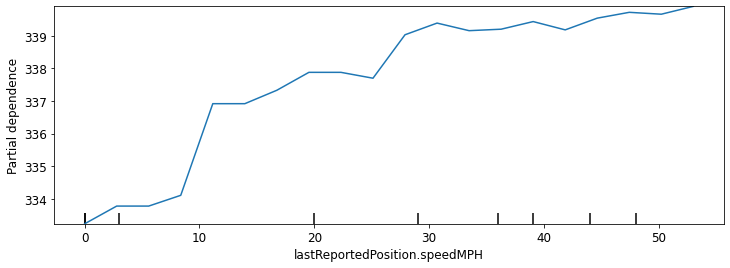

In [88]:
from sklearn.inspection import plot_partial_dependence

fig,ax = plt.subplots(figsize=(12, 4))
plot_partial_dependence(m, xs, ['lastReportedPosition.speedMPH'],
                        grid_resolution=20, ax=ax);

This is sort of a dur moment, saying "Speeds don't change a lot one milepost to the next".  

#Random Forest

In [89]:
def randomForest(xs, y, n_estimators=50, max_samples=2500,
       max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

In [90]:
m = randomForest(xs, y);

In [91]:
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(3.521698, 5.358647)

In [ ]:
preds = np.stack([t.predict(valid_xs) for t in m.estimators_])

In [93]:
r_mse(preds.mean(0), valid_y)

5.358647

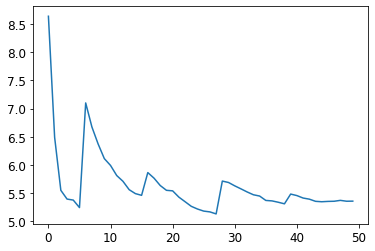

In [94]:
plt.plot([r_mse(preds[:i+1].mean(0), valid_y) for i in range(50)]);

### Out-of-Bag Error

In [95]:
r_mse(m.oob_prediction_, y)

4.47393

- How confident are we in our predictions using a particular row of data?
- For predicting with a particular row of data, what were the most important factors, and how did they influence that prediction?
- Which columns are the strongest predictors, which can we ignore?
- Which columns are effectively redundant with each other, for purposes of prediction?
- How do predictions vary, as we vary these columns?


In [ ]:
preds = np.stack([t.predict(valid_xs) for t in m.estimators_])

In [97]:
preds.shape

(50, 1629)

In [98]:
preds_std = preds.std(0)

In [99]:
preds_std[:5]

array([27.28854112, 27.29543141, 27.05576205, 27.05576205,  4.30394882])

In [100]:
print(preds.mean(0)[:10])
print(valid_y[:10])

[756.96183208 756.77693883 755.90390823 755.90390823 207.99049019 210.26925313 226.50264669 235.77005535 245.48372132 257.59247134]
10     765.453430
55     766.232788
56     766.232605
57     766.065430
98     203.465088
99     216.631958
100    227.721283
101    238.108032
102    248.636780
103    260.765839
Name: nextValue, dtype: float32


# FEATURE Importance

In [101]:
fi = rf_feat_importance(m, xs)
fi[:20]

,cols,imp
23,lastReportedPosition.milepostLocation.milepost.milepostNumber,0.580946
38,milepost,0.327744
14,workLocations,0.079909
39,locomotiveCount,0.008025
12,mpIncr,0.001534
22,lastReportedPosition.speedMPH,0.000858
6,lastReportedPosition.milepostLocation.trackName,0.000200
0,ptcLeadLocomotiveId,0.000084
4,trainId.trainDate,0.000078
37,trailingTonnage,0.000067


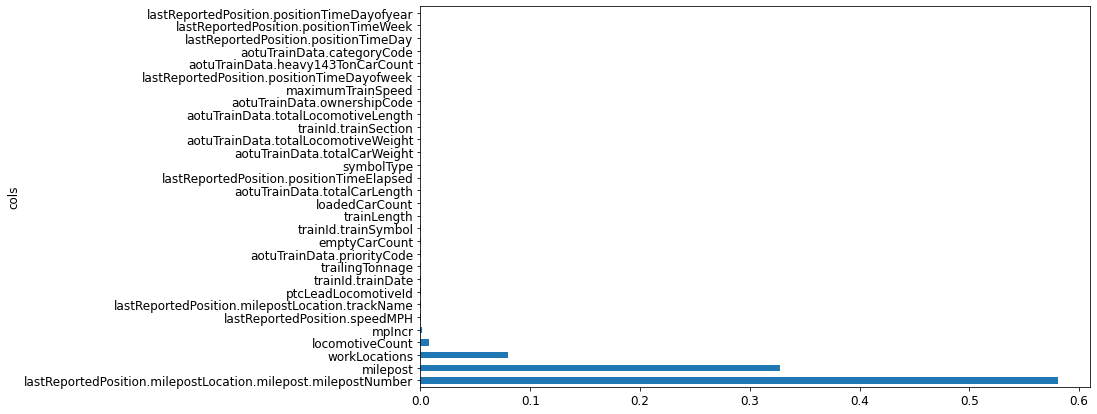

In [102]:
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

plot_fi(fi[:30]);

Remove low importance columns

In [107]:
to_keep = fi[fi.imp>0.0002].cols
len(to_keep)

7

In [108]:
xs_imp = xs[to_keep]
valid_xs_imp = valid_xs[to_keep]

In [109]:
m = randomForest(xs_imp, y)

In [110]:
m_rmse(m, xs_imp, y), m_rmse(m, valid_xs_imp, valid_y)

(4.08522, 5.316383)

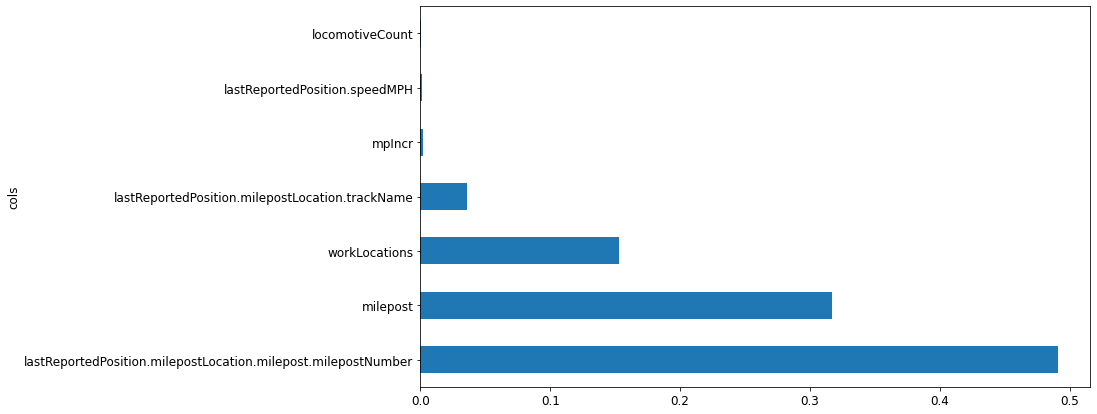

In [111]:
plot_fi(rf_feat_importance(m, xs_imp));

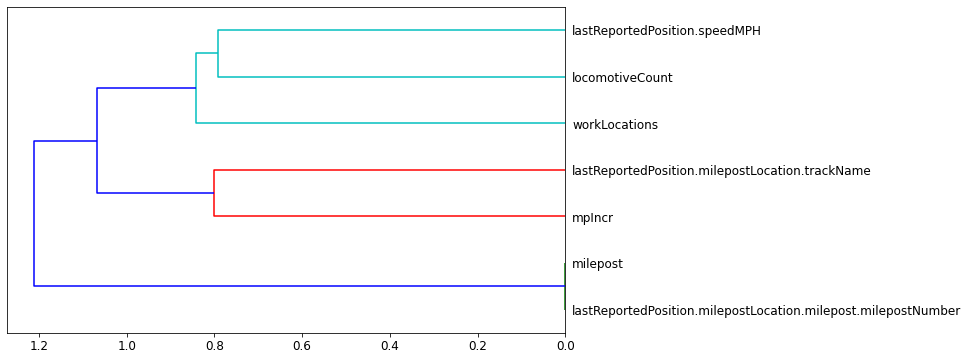

In [112]:
fastai.cluster_columns(xs_imp)

# Compute the Physics Model loss for the same interval:

In [114]:
b = dfTrainsNextBeop.tail(14165)
# beopValues = beopValues.to_frame().join(valid_y)
#m_rmse(m, valid_xs_imp, valid_y)
b = b.reset_index(drop=true)
#print (b)
y = valid_y.reset_index(drop=true)
#print (y)
df2  = pd.concat([b, y], axis=1)
df2.dropna()
print(df2)
r_mse(df2['beopValue'], df2['nextValue'])
# print(BeopValidations[:5])
#print(valid_y[:5])

      beopValue   nextValue
0           NaN  765.453430
1           NaN  766.232788
2           NaN  766.232605
3     731.84210  766.065430
4     738.46490  203.465088
...         ...         ...
5902  302.52744         NaN
5903  305.07630         NaN
5904        NaN         NaN
5905  309.55542         NaN
5906  321.79720         NaN

[5907 rows x 2 columns]


264.716904

# Finding Out-of-Domain Data
Spot variables that are unique to the test set versus the training set

In [115]:
df_dom = pd.concat([xs, valid_xs])
is_valid = np.array([0]*len(xs) + [1]*len(valid_xs))

m = randomForest(df_dom, is_valid)
rf_feat_importance(m, df_dom)[:8]

,cols,imp
44,lastReportedPosition.positionTimeDayofyear,0.440000
45,lastReportedPosition.positionTimeElapsed,0.403743
42,lastReportedPosition.positionTimeDay,0.109752
41,lastReportedPosition.positionTimeWeek,0.040526
40,lastReportedPosition.positionTimeMonth,0.004038
19,lastReportedPosition.positionTimeIs_quarter_start,0.001941
32,aotuTrainData.highWideCarCount,0.000000
26,aotuTrainData.totalLocomotiveWeight,0.000000


Consider whether these values make sense

#Using a Neural Net

In [116]:
df_nn_final = dfTrainsLearn

In [117]:
df_nn_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5907 entries, 10 to 6745
Data columns (total 47 columns):
 #   Column                                                         Non-Null Count  Dtype         
---  ------                                                         --------------  -----         
 0   ptcLeadLocomotiveId                                            5907 non-null   object        
 1   trainId.trainSCAC                                              5907 non-null   category      
 2   trainId.trainSection                                           5907 non-null   category      
 3   trainId.trainSymbol                                            5907 non-null   object        
 4   trainId.trainDate                                              5907 non-null   datetime64[ns]
 5   lastReportedPosition.speedMPH                                  5907 non-null   int64         
 6   lastReportedPosition.milepostLocation.subdivisionId            5907 non-null   int64         
 

In [118]:
cont_nn,cat_nn = cont_cat_split(df_nn_final, max_card=9000, dep_var=dep_var)

In [119]:
cont_nn

['lastReportedPosition.milepostLocation.milepost.milepostNumber',
 'aotuTrainData.totalCarWeight',
 'aotuTrainData.totalCarLength',
 'aotuTrainData.totalLocomotiveWeight',
 'aotuTrainData.totalLocomotiveLength',
 'aotuTrainData.actualTonsPerAxle',
 'aotuTrainData.heavy143TonCarCount',
 'aotuTrainData.heavy158TonCarCount',
 'aotuTrainData.over158TonCarCount',
 'aotuTrainData.highWideCarCount',
 'maximumTrainSpeed',
 'loadedCarCount',
 'emptyCarCount',
 'trainLength',
 'trailingTonnage',
 'lastReportedPosition.positionTimeElapsed']

In [120]:
numUniquePerCat = df_nn_final[cat_nn].nunique()
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  
    print(numUniquePerCat)

ptcLeadLocomotiveId                                    446
trainId.trainSCAC                                        1
trainId.trainSection                                     5
trainId.trainSymbol                                    160
trainId.trainDate                                       19
lastReportedPosition.speedMPH                           71
lastReportedPosition.milepostLocation.subdivisionId      1
lastReportedPosition.milepostLocation.trackName         33
aotuTrainData.priorityCode                               5
aotuTrainData.categoryCode                              15
aotuTrainData.authorityRangeCode                         4
aotuTrainData.ownershipCode                              3
aotuTrainData.eventCode                                  1
milepost                                               224
mpIncr                                                   2
symbolType                                              16
workLocations                                           

In [121]:
procs_nn = [Categorify, FillMissing, Normalize]
to_nn = TabularPandas(df_nn_final, procs_nn, cat_nn, cont_nn,
                      splits=splits, y_names=dep_var)

In [122]:
dls = to_nn.dataloaders(1024)

In [123]:
y = to_nn.train.y
y.min(),y.max()

(202.2868, 767.9998)

In [126]:
learn = tabular_learner(dls, y_range=(202,768), layers=[500,250],
                        n_out=1, loss_func=F.mse_loss)

SuggestedLRs(valley=0.0014454397605732083)

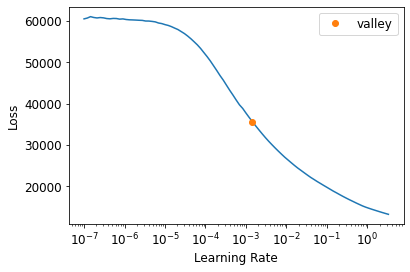

In [127]:
learn.lr_find()

In [128]:
learn.fit_one_cycle(50, 1e-2)

epoch,train_loss,valid_loss,time
0,29273.796875,54725.320312,00:00
1,16697.917969,53223.906250,00:00
2,11490.997070,52836.960938,00:00
3,8797.094727,58642.113281,00:00
4,7152.245117,65080.722656,00:00
5,6070.864258,64927.421875,00:00
6,5302.143066,52797.281250,00:00
7,4723.321289,26898.857422,00:00
8,4269.284668,26787.707031,00:00
9,3893.343750,14104.218750,00:00


In [129]:
preds,targs = learn.get_preds()
print(r_mse(preds,targs))
print(preds[:10])
print(targs[:10])

24.720894
tensor([[767.8796],
        [767.8268],
        [767.8875],
        [767.8873],
        [212.7435],
        [213.1347],
        [219.2676],
        [221.1059],
        [227.0024],
        [233.5098]])
tensor([[765.4534],
        [766.2328],
        [766.2326],
        [766.0654],
        [203.4651],
        [216.6320],
        [227.7213],
        [238.1080],
        [248.6368],
        [260.7658]])
